In [3]:
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models
from torch.utils.data import sampler
import math
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

In [4]:
#torch.cuda.set_device(0)
# specify dtype
use_cuda = torch.cuda.is_available()
if use_cuda:
    dtype = torch.cuda.FloatTensor
else:
    dtype = torch.FloatTensor
print(torch.cuda.device_count())
print(use_cuda)

1
True


In [5]:
# Hyperparameters
batch_size = 32
learning_rate = 4e-3
momentum = 0.9
num_epoch = 15

In [6]:
# Data
class ChunkSampler(sampler.Sampler):
    """Samples elements sequentially from some offset. 
    Arguments:
        num_samples: # of desired datapoints
        start: offset where we should start selecting from
    """
    def __init__(self, num_samples, start = 0):
        self.num_samples = num_samples
        self.start = start

    def __iter__(self):
        return iter(range(self.start, self.start + self.num_samples))

    def __len__(self):
        return self.num_samples

data_path = '/home/put_data/frank840925/IDP/data'
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])

trainset = torchvision.datasets.CIFAR10(root=data_path, 
                                        train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=4)

valset = torchvision.datasets.CIFAR10(root=data_path, 
                                       train=False, download=True, transform=transform)
valloader = torch.utils.data.DataLoader(valset, batch_size=batch_size, shuffle=False, sampler=ChunkSampler(5000,0), 
                                       num_workers=4)

testset = torchvision.datasets.CIFAR10(root=data_path, 
                                       train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, sampler=ChunkSampler(5000,5000),
                                        num_workers=4)

print(trainset.__len__())
print(valset.__len__())
print(testset.__len__())

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
50000
10000
10000


In [7]:
# functions to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

def plot_losses(loss_history1=None, loss_history2=None):
    plt.clf()
    fig = plt.figure()
    ax1 = fig.add_subplot(111)
    if loss_history1:
        ax1.plot(loss_history1, color="blue", label="train")
    if loss_history2:
        ax1.plot(loss_history2, color="green", label="test")
    #ax2 = ax1.twinx()
    #ax2.set_yscale('log')
    plt.xlabel("epoch") 
    plt.ylabel("loss") 
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.title("Cross-entropy loss")
    #plt.savefig('output_losses.png')

def plot_accuracy(accuracy1=None, accuracy2=None):
    plt.clf()
    fig2 = plt.figure()
    ax1 = fig2.add_subplot(111)
    if accuracy1:
        ax1.plot(accuracy1, color="red", label="train")
    if accuracy2:
        ax1.plot(accuracy2, color="black", label="test")
    plt.xlabel("epoch") 
    plt.ylabel("accuracy")
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.title("Train/Test accuracy") 
    #plt.savefig('accuracy.png')

# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()
print(images.shape)

torch.Size([32, 3, 32, 32])


In [8]:
# self-defined modules(layers)
class Flatten(nn.Module):
    def forward(self, x):
        # read in N, C, H, W
        N, C, H, W = x.size()
        # flatten the C * H * W values into a single vector per image
        return x.view(N, -1)
        
class idp_tensor(nn.Module):
    def __init__(self, idp):
        super(idp_tensor, self).__init__()
        self.idp = idp
    def forward(self, c):
        #input tensor c, size N*C*H*W, output with the same size, some channels zeroed according to idp
        N, C, H, W = c.size()
        non_zero_channel = int(C*(self.idp))
        zero_channels = C-non_zero_channel
        if zero_channels > 0:
            #zeros = Variable(torch.zeros(N, zero_channels, H, W)).type(dtype)
            zeros = Variable(torch.zeros(zero_channels).view(zero_channels,1)).type(dtype) #C
            zeros = zeros.expand(zero_channels, H) #C*H
            zeros = torch.stack([zeros]*W,1) #C*H*W
            zeros = torch.stack([zeros]*N) #N*C*H*W
            c = torch.cat([c[:, :non_zero_channel, :, :].clone(), zeros], 1).type(dtype)
            #c[:, non_zero_channel:, :, :] = zeros
            return c
        else:
            return c

class func_linear(nn.Module):
    def __init__(self, k=1):
        super(func_linear, self).__init__()
        self.k = k
    def channel_coeff(self, N, C, H, W):
        coeff_list = list(map(lambda a: 1-(a/(C+1)), range(0,C)))
        coeff_list = [[c] for c in coeff_list]
        coeff = Variable(torch.Tensor(coeff_list)).type(dtype) #C
        coeff_tensor = coeff.expand(C,H) #C*H
        coeff_tensor = torch.stack([coeff_tensor]*W,1) #C*H*W
        coeff_tensor = torch.stack(([coeff_tensor]*N)) #N*C*H*W
        return coeff_tensor

    def forward(self, x):
        N, C, H, W = x.size()
        x = torch.mul(x.clone(), self.channel_coeff(N, C, H, W))
        return x

In [9]:
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        self.features = nn.Sequential(nn.Conv2d(3, 16, 5),
                                      nn.ReLU(True),
                                      nn.MaxPool2d(2),
                                      nn.Conv2d(16, 32, 5),
                                      nn.ReLU(True),
                                      nn.MaxPool2d(2))
        self.classifier = nn.Sequential(nn.Linear(32*5*5, 120),
                                        nn.ReLU(True),
                                        nn.Linear(120, 84),
                                        nn.ReLU(True),
                                        nn.Linear(84, 10))

    def forward(self, x):
        out = self.features(x)
        out = out.view(out.size(0), -1)
        out = self.classifier(out)
        return out

In [10]:
lenet = LeNet().type(dtype)
print(list(lenet.features.children()))

[Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1)), ReLU (inplace), MaxPool2d (size=(2, 2), stride=(2, 2), dilation=(1, 1)), Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1)), ReLU (inplace), MaxPool2d (size=(2, 2), stride=(2, 2), dilation=(1, 1))]


In [11]:
x = Variable(torch.randn(8,3,32,32)).type(dtype)
lenet(x).size()

torch.Size([8, 10])

In [12]:
class linear_idp_lenet(nn.Module):
    def __init__(self, idp_layers, model, idp=1):
        #idp is 0~1, idp_layers is a set, specify which layer in features should apply idp
        #now idp_layers is 1,4
        super(linear_idp_lenet, self).__init__()
        self.idp = idp
        self.idp_layers = idp_layers
        self.features = nn.Sequential(*(self.new_features_list(model)))
        self.classifier = model.classifier
        
    def new_features_list(self, model):
        new_layers = nn.ModuleList()
        for i, layer in enumerate(list(model.features.children())):
            if i not in self.idp_layers:
                new_layers.append(layer)                
            else:
                new_layers.append(layer)
                new_layers.append(func_linear())
                new_layers.append(idp_tensor(self.idp))
        new_layers.append(Flatten())
        return new_layers        
    
    def forward(self, x):
        out = self.features(x)
        out = self.classifier(out)
        return out

In [14]:
idp = 1
idp_layers = {1,4}
net = linear_idp_lenet(idp_layers, lenet, 1).type(dtype)

In [15]:
net

linear_idp_lenet (
  (features): Sequential (
    (0): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU (inplace)
    (2): func_linear (
    )
    (3): idp_tensor (
    )
    (4): MaxPool2d (size=(2, 2), stride=(2, 2), dilation=(1, 1))
    (5): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1))
    (6): ReLU (inplace)
    (7): func_linear (
    )
    (8): idp_tensor (
    )
    (9): MaxPool2d (size=(2, 2), stride=(2, 2), dilation=(1, 1))
    (10): Flatten (
    )
  )
  (classifier): Sequential (
    (0): Linear (800 -> 120)
    (1): ReLU (inplace)
    (2): Linear (120 -> 84)
    (3): ReLU (inplace)
    (4): Linear (84 -> 10)
  )
)

In [19]:
x = Variable(torch.randn(8,3,32,32)).type(dtype)
net(x).size()

torch.Size([8, 10])

In [16]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=momentum)

In [17]:
def train(num_epoch, net, criterion, optimizer):
    train_loss = []
    test_loss = []
    train_acc = []
    test_acc = []

    # start training
    for epoch in range(num_epoch):  # loop over the dataset multiple times
        running_loss1 = []
        running_loss2 = []
        running_correct1=[]
        running_correct2=[]
        for i, data in enumerate(trainloader, 0):
            correct = 0
            net.train(True)
            # get the inputs
            inputs, labels = data
            # wrap them in Variable
            inputs, labels = Variable(inputs).type(dtype), Variable(labels).type(torch.cuda.LongTensor)
            # zero the parameter gradients
            optimizer.zero_grad()
            # forward + backward + optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            # print statistics
            # loss
            running_loss1.append(loss.data[0])
            # accuracy
            _, predicted = torch.max(outputs.data, 1)
            correct += (predicted == labels.data).sum()
            correct = correct/labels.size(0)*100
            running_correct1.append(correct)

        for i, tdata in enumerate(valloader, 0):
            test_correct = 0
            net.train(False)
            tinputs, tlabels = tdata
            tinputs, tlabels = Variable(tinputs).type(dtype), Variable(tlabels).type(torch.cuda.LongTensor)
            toutput = net(tinputs)
            tloss = criterion(toutput, tlabels)
            running_loss2.append(tloss.data[0])
            _, tpredicted = torch.max(toutput.data, 1)
            test_correct += (tpredicted == tlabels.data).sum()
            test_correct = test_correct/tlabels.size(0)*100
            running_correct2.append(test_correct)

        train_loss.append(np.mean(running_loss1))
        test_loss.append(np.mean(running_loss2))
        train_acc.append(np.mean(running_correct1))
        test_acc.append(np.mean(running_correct2))

        #statistics
        print('Epoch [%d/%d], Train Loss:%.3f, Val Loss:%.3f, Train Accuracy:%.3f percent, Val Accuracy:%.3f percent' 
                    %(epoch+1, num_epoch, train_loss[-1], test_loss[-1], train_acc[-1], test_acc[-1]))
        #save model every 10 epoch
        if epoch!=0 and epoch%10 ==0:
            file = 'saved_models/'+str(epoch)+'_epoch_30_linear_idp_model.pkl'
            torch.save(net.state_dict(), file)
        #early stopping
        if epoch >= 4:
            if (test_acc[-1] - test_acc[-2]) <=0 and (test_acc[-1] - test_acc[-3]) <= 0 and (test_acc[-1] - test_acc[-4]) <= 0:
                print('Early stopping')
                return train_loss, test_loss, train_acc, test_acc
            else:
                continue
        
    print('Finished Training')
    return train_loss, test_loss, train_acc, test_acc

In [20]:
train_loss, test_loss, train_acc, test_acc = train(num_epoch, net, criterion, optimizer)

Epoch [1/15], Train Loss:1.816, Val Loss:1.526, Train Accuracy:33.111 percent, Val Accuracy:43.690 percent
Epoch [2/15], Train Loss:1.379, Val Loss:1.260, Train Accuracy:50.050 percent, Val Accuracy:55.932 percent
Epoch [3/15], Train Loss:1.213, Val Loss:1.206, Train Accuracy:56.508 percent, Val Accuracy:56.568 percent
Epoch [4/15], Train Loss:1.095, Val Loss:1.100, Train Accuracy:61.226 percent, Val Accuracy:61.863 percent
Epoch [5/15], Train Loss:1.001, Val Loss:1.043, Train Accuracy:64.541 percent, Val Accuracy:64.092 percent
Epoch [6/15], Train Loss:0.922, Val Loss:1.004, Train Accuracy:67.598 percent, Val Accuracy:65.147 percent
Epoch [7/15], Train Loss:0.858, Val Loss:0.997, Train Accuracy:69.822 percent, Val Accuracy:66.083 percent
Epoch [8/15], Train Loss:0.806, Val Loss:1.000, Train Accuracy:71.521 percent, Val Accuracy:66.521 percent
Epoch [9/15], Train Loss:0.753, Val Loss:0.972, Train Accuracy:73.209 percent, Val Accuracy:67.795 percent
Epoch [10/15], Train Loss:0.709, Val 

In [21]:
# Save the Model
torch.save(net.state_dict(), 'saved_models/linear_lenet.pkl')

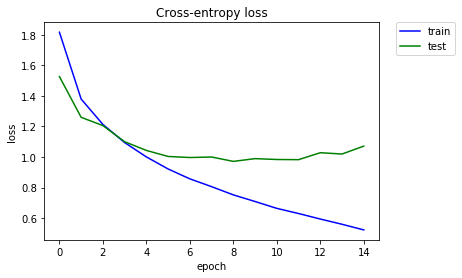

In [22]:
plot_losses(train_loss, test_loss)

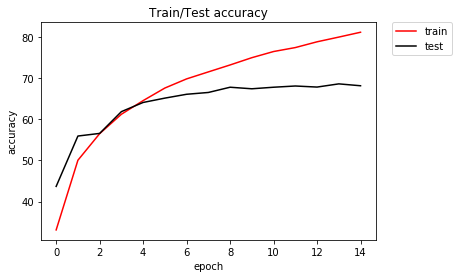

In [23]:
plot_accuracy(train_acc, test_acc)

In [24]:
# Load the trained model
net.load_state_dict(torch.load('saved_models/linear_lenet.pkl'))

In [25]:
def test_acccuracy(testloader, model):
    correct = 0
    total = 0
    for data in testloader:
        images, labels = data
        outputs = model(Variable(images, volatile=True).type(dtype))
        labels = Variable(labels, volatile=True).type(torch.cuda.LongTensor)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels.data).sum()
    acc = 100*correct/total
    print('Accuracy of the network on the 10000 test images: %d %%' % (acc))
    return acc

test_acccuracy(testloader, net.eval())

Accuracy of the network on the 10000 test images: 68 %


68.34

In [27]:
idp_acc_history = []
idp_harmonic_history = [0]*20

idp_scale = list(map(lambda x: x/20,range(2,21)))
print(idp_scale)
for i in idp_scale:
    net_inference = linear_idp_lenet(idp_layers, lenet, idp=i).type(dtype)
    net_inference.load_state_dict(torch.load('saved_models/linear_lenet.pkl'))
    a = test_acccuracy(testloader, net_inference.eval())
    idp_acc_history.append(a)

[0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 1.0]
Accuracy of the network on the 10000 test images: 9 %
Accuracy of the network on the 10000 test images: 10 %
Accuracy of the network on the 10000 test images: 15 %
Accuracy of the network on the 10000 test images: 30 %
Accuracy of the network on the 10000 test images: 31 %
Accuracy of the network on the 10000 test images: 29 %
Accuracy of the network on the 10000 test images: 34 %
Accuracy of the network on the 10000 test images: 32 %
Accuracy of the network on the 10000 test images: 36 %
Accuracy of the network on the 10000 test images: 35 %
Accuracy of the network on the 10000 test images: 47 %
Accuracy of the network on the 10000 test images: 58 %
Accuracy of the network on the 10000 test images: 64 %
Accuracy of the network on the 10000 test images: 65 %
Accuracy of the network on the 10000 test images: 66 %
Accuracy of the network on the 10000 test images: 67 %
Accuracy of the 

In [28]:
idp_acc_history

[9.9,
 10.4,
 15.96,
 30.8,
 31.76,
 29.68,
 34.02,
 32.18,
 36.04,
 35.2,
 47.32,
 58.24,
 64.18,
 65.84,
 66.94,
 67.66,
 68.42,
 68.32,
 68.34]

In [29]:
def plot_idp_accuracy(accuracy1=None, accuracy2=None):
    plt.clf()
    fig3 = plt.figure()
    ax1 = fig3.add_subplot(111)
    idp_scale = list(map(lambda x: x/20,range(2,21)))
    idp_scale_i = [i for i in range(0, len(idp_scale))]
    if accuracy1:
        ax1.plot(idp_scale_i, accuracy1, marker='o', linestyle='-', color='r', label="linear")
    if accuracy2:
        ax1.plot(idp_scale_i, accuracy2, 'g^', label="harmonic")
    plt.xticks(idp_scale_i, idp_scale)
    plt.xlabel("Tesla-Linear-IDP") 
    plt.ylabel("Accuracy(%)")
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.title("Lenet5(CIFAR-10)")

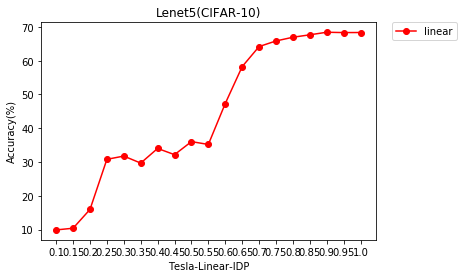

In [30]:
plot_idp_accuracy(idp_acc_history)

In [36]:
def plot_idp_accuracy(accuracy1=None, accuracy2=None, accuracy3=None, accuracy4=None, accuracy5=None, accuracy6=None,
                     accuracy7=None, accuracy8=None, accuracy9=None):
    plt.clf()
    fig4 = plt.figure()
    ax1 = fig4.add_subplot(111)
    idp_scale = list(map(lambda x: x/20,range(2,21)))
    idp_scale_i = [i for i in range(0, len(idp_scale))]
    if accuracy1:
        ax1.plot(idp_scale_i, accuracy1, marker='o', linestyle='-', color='r', label="Linear")
    if accuracy2:
        ax1.plot(idp_scale_i, accuracy2, marker='o', linestyle='--', color='g', label="Tesla-Linear-100-50-20")
    if accuracy3:
        ax1.plot(idp_scale_i, accuracy3, marker='o', linestyle='--', color='b', label="ATP-100-50-20")
    if accuracy4:
        ax1.plot(idp_scale_i, accuracy4, marker='o', linestyle='--', color='gray', label="Tesla-35-100-Linear")
    if accuracy5:
        ax1.plot(idp_scale_i, accuracy5, marker='o', linestyle='--', color='y', label="Tesla-50-100-Linear")
    if accuracy6:
        ax1.plot(idp_scale_i, accuracy6, marker='o', linestyle='--', color='purple', label="Tesla-100-35-Linear")
    if accuracy7:
        ax1.plot(idp_scale_i, accuracy7, marker='o', linestyle='--', color='pink', label="Tesla-100-70-35-Linear")
    if accuracy8:
        ax1.plot(idp_scale_i, accuracy8, marker='o', linestyle='--', color='orange', label="Tesla-100-35-10-Linear")
    if accuracy9:
        ax1.plot(idp_scale_i, accuracy9, marker='o', linestyle='--', color='aqua', label="Tesla-100-50-20-Linear")
    plt.xticks(idp_scale_i, idp_scale)
    plt.xlabel("IDP") 
    plt.ylabel("Accuracy(%)")
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.title("Lenet(CIFAR-10)") 
    plt.savefig('results_graphs/lenet_accuracy.png')

In [37]:
tesla=[16.96,
 15.68,
 52.16,
 28.32,
 28.06,
 29.4,
 31.16,
 52.46,
 63.62,
 62.7,
 63.14,
 62.32,
 63.52,
 65.88,
 66.32,
 66.62,
 66.74,
 66.94,
 66.72]

In [38]:
atp=[10.78,
 29.74,
 54.04,
 39.66,
 39.58,
 24.32,
 48.32,
 54.94,
 63.36,
 60.12,
 54.98,
 46.62,
 52.02,
 51.84,
 51.3,
 53.04,
 53.34,
 61.06,
 68.04]

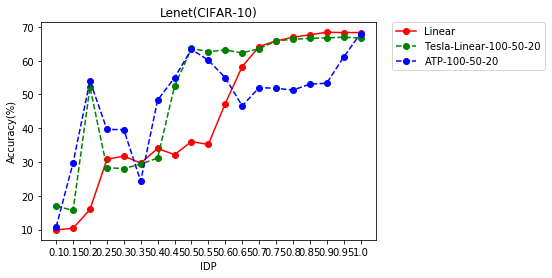

In [39]:
plot_idp_accuracy(idp_acc_history, tesla, atp)